In [25]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from gluonts.time_feature import (
    get_lags_for_frequency, 
    time_features_from_frequency_str
)

from transformers import TimeSeriesTransformerConfig

from src.utils import create_test_dataset
from src import ts_transformer as tsf
from src.plotting import plot

# Split dataset

In [11]:
# Assumes pandas.DataFrame <data> in the following format:
# | target | start | feat_static_cat | feat_static_real | feat_dynamic_real | item_id |

data.head()

,target,start,feat_static_cat,feat_dynamic_real,item_id
0,"[1.62, 1.61, 1.57, 1.48, 1.75, 1.85, 1.79, 1.9...",2017-03-26,"[12, 0, 3]",None,T1
1,"[8.9, 8.5, 9.5, 7.7, 8.1, 10.6, 16.7, 12.2, 10...",2017-07-02,"[26, 1, 0]",None,T2
2,"[12.7, 13.6, 10.8, 7.8, 10.6, 10.9, 13.3, 14.7...",2017-07-02,"[26, 1, 2]",None,T3
3,"[8.85, 8.88, 8.12, 8.81, 8.51, 11.26, 12.33, 1...",2017-09-10,"[36, 2, 0]",None,T4
4,"[7.7, 7.2, 8.5, 8.6, 6.2, 6.9, 7.1, 8.4, 11.4,...",2017-10-22,"[42, 1, 3]",None,T5


In [13]:
prediction_length = 24
context_length = 48

freq = '1H'

transformer_config = {
    'prediction_length': prediction_length,
    'context_length': context_length,
    'num_static_categorical_features': 3,
    'cardinality': [52,3,4],
    'embedding_dimension': [2,2,2],
    'encoder_layers': 4,
    'decoder_layers': 4,
    'd_model': 32,
}

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=42)
train_df = train_df.reset_index(drop=True)

#need to split the original series into series of length context+prediction
test_df = test_df.reset_index(drop=True)
new_test_df = create_test_dataset(test_df, context_length+prediction_length)

#get a fraction
frac_test_df = new_test_df.sample(frac=0.1, random_state=42)

# Transformer TSF

## Training

In [17]:
batch_size = 32
num_batches_per_epoch = 16
epochs = 400

In [18]:
transformer, train_dataloader, test_dataloader, test_data = tsf.setup_training(
    train_df=train_df,
    test_df=frac_test_df,
    freq=freq,
    batch_size = batch_size,
    num_batches_per_epoch = num_batches_per_epoch,
    transformer_config=transformer_config
)

In [19]:
transformer, list_loss = tsf.train(transformer, train_dataloader, epochs)

Using default AdamW parametres.


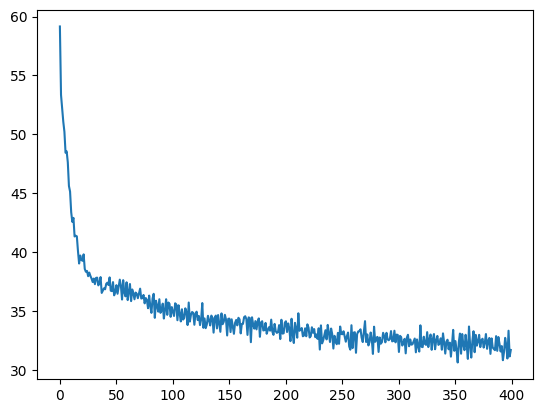

In [20]:
plt.plot(list_loss)

## Evaluate

In [21]:
forecasts = tsf.test(transformer, test_dataloader)

In [22]:
mase, smape = tsf.evaluate(
    test_data,
    forecasts,
    transformer_config['prediction_length'],
    freq)

print(f"MASE: {np.mean(mase)}")

print(f"sMAPE: {np.mean(smape)}")

MASE: 1.0119227766216763
sMAPE: 0.1748894679081952


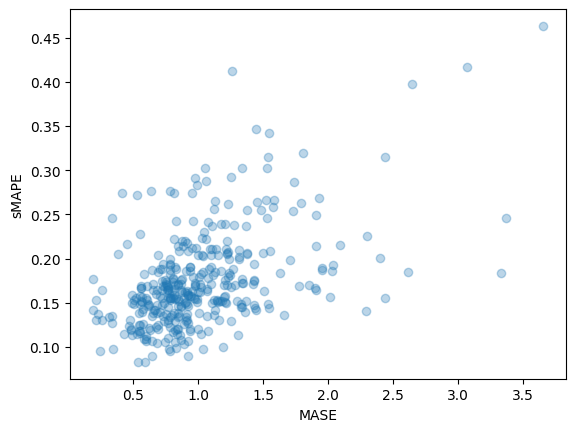

In [23]:
plt.scatter(mase, smape, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

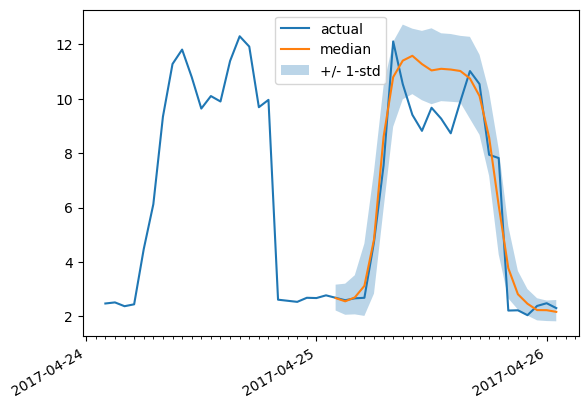

In [36]:
plot(0, test_data, forecasts, prediction_length)

# LSTM

We can compare the results to a basic LSTM model

## Training

In [ ]:
# Using same train_df as before
lstm_data = np.array(train_df['target'].to_list())
lstm_data.shape

In [ ]:
X_all, y_all = [], []

for series in scaled_series:
    X, y = create_sequences(series, prediction_length, context_length)
    X_all.append(X)
    y_all.append(y)

# Combine all sequences from different sensors into one dataset
X_combined = np.concatenate(X_all, axis=0)
y_combined = np.concatenate(y_all, axis=0)

X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

In [ ]:
X_train = np.expand_dims(X_combined, axis=2)
X_train = torch.Tensor(X_train)

y_train = torch.Tensor(y_combined)

In [ ]:
tensor_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=True)

In [ ]:
input_size = 1  # Univariate
hidden_layer_size = 50 
num_layers = 2

lstm = LSTMModel(input_size, hidden_layer_size, prediction_length, num_layers)
lstm.to(lstm.device)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=0.001)


In [ ]:
#5min
epochs = 200  # Example number of epochs
epoch_losses = []

for epoch in range(epochs):
    lstm.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        # Move the batch of inputs and labels to the appropriate device
        inputs, labels = inputs.to(lstm.device), labels.to(lstm.device)

        optimizer.zero_grad()  # Clear the gradients in the optimizer
        outputs = lstm(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    epoch_losses.append(avg_loss)
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')

In [ ]:
plt.figure(figsize=(6, 4))
plt.plot(epoch_losses, label='LSTM Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()


## Testing

In [ ]:
test_lstm = np.array(frac_test_df['target'].to_list())

#split in context and prediction
X_test = test_lstm[:, :context_length]
y_test = test_lstm[:, context_length:]

X_test = np.expand_dims(X_test, axis=2)
X_test = torch.Tensor(X_test)

y_test = torch.Tensor(y_test)

In [ ]:
tensor_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(tensor_data, batch_size=batch_size, shuffle=False)

In [ ]:
lstm.eval()

forecasts_lstm = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(lstm.device), labels.to(lstm.device)
        outputs = lstm(inputs)
        outputs = outputs.detach().cpu().numpy()
        forecasts_lstm.append(outputs)

forecasts_lstm = np.vstack(forecasts_lstm)

In [ ]:
#1min
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

mase_metrics_lstm = []
smape_metrics_lstm = []
for item_id, (input_, true) in enumerate(tensor_data):
    mase = mase_metric.compute(
        predictions=forecasts_lstm[item_id], 
        references=np.array(true),
        training=np.array(input_), 
        periodicity=get_seasonality(freq))
    mase_metrics_lstm.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecasts_lstm[item_id], 
        references=np.array(true), 
    )
    smape_metrics_lstm.append(smape["smape"])

    if item_id % 100 == 0:
        print(item_id)


In [ ]:
print(f"MASE: {np.mean(mase_metrics_lstm)}")

print(f"sMAPE: {np.mean(smape_metrics_lstm)}")

plt.scatter(mase_metrics_lstm, smape_metrics_lstm, alpha=0.3, color='red', label='LSTM')
plt.scatter(mase_metrics_transformer, smape_metrics_transformer, alpha=0.15, color='blue', label='Transformer')
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(6, 4))

ax1 = plt.gca()
line1, = ax1.plot(epoch_losses, label='LSTM RMSE Training Loss', color='r')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('LSTM RMSE Training Loss')

ax2 = ax1.twinx()
line2, = ax2.plot(list_loss, label='Transformer NLL Training Loss', color='b')
ax2.set_ylabel('Transformer NLL Training Loss')

lines = [line1, line2]
labels = [line.get_label() for line in lines]

ax1.legend(lines, labels, loc='upper right')